In [168]:
# Import the necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import trading_env
import strategies
import pandas as pd

# Environment parameters
env_config = {
    "ticker" : "QQQ",
    "starting_equity" : 100,
    "step_contribution" : 1,
    "start_timestamp" : 933255000,
}
episode_length = 90

# Initialize the strategies
strategy_list = {
    "Do Nothing" : strategies.DoNothingStrategy(),
    "Buy and Hold" : strategies.BuyAndHoldStrategy(),
    "PPO" : strategies.PPOStrategy(quiet=True),
}

In [169]:
result_dfs = {}
for strategy_name, strategy_obj in strategy_list.items():
    # Initalize environment
    env = trading_env.TradingEnv(env_config={"episode_length": episode_length})
    state, info = env.reset(options=env_config)
    state_dict = trading_env.unflatten_dictarr(state)

    # Intialize df columns
    df = pd.DataFrame(columns=["close", "cash", "long", "equity", "annotations"], index=range(episode_length+1))
    df.loc[0, "close"] = state_dict["close"][-1]
    df.loc[0, "cash"] = state_dict["cash"]
    df.loc[0, "long"] = state_dict["long"]
    df.loc[0, "equity"] = state_dict["cash"] + state_dict["long"]*(state_dict["close"][-1])
    df.loc[0, "annotations"] = 0

    # Run the strategy
    terminated = truncated = False
    i = 0
    while not (terminated or truncated):
        action = strategy_obj.get_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        state_dict = trading_env.unflatten_dictarr(state)
        i += 1
        
        price = state_dict["close"][-1]
        df.loc[i, "close"] = price
        df.loc[i, "cash"] = state_dict["cash"]
        df.loc[i, "long"] = state_dict["long"]
        df.loc[i, "equity"] = state_dict["cash"] + state_dict["long"]*price
        df.loc[i, "annotations"] = action[0]
    
    # Save the results
    result_dfs[strategy_name] = df

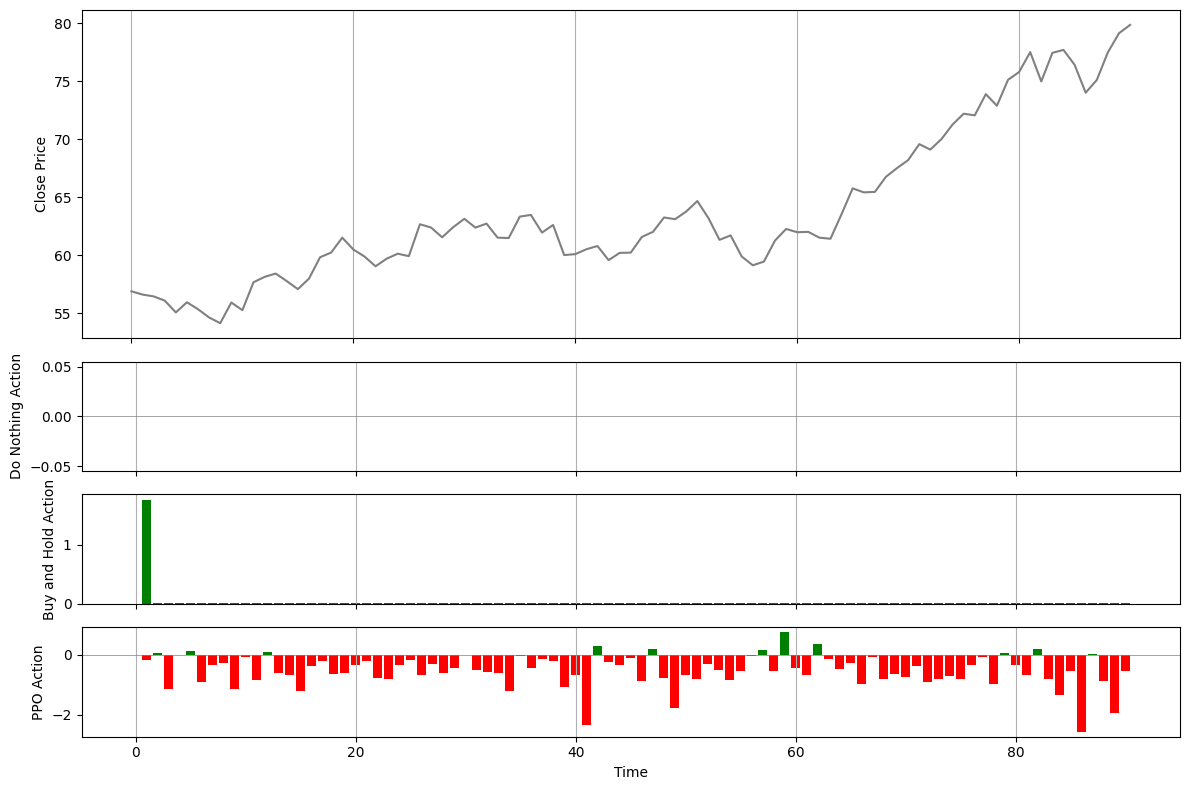

In [170]:
timeline = np.arange(episode_length+1)
strategy_names = list(strategy_list.keys())
strategy_count = len(strategy_names)

height_ratios = np.ones(strategy_count+1)
height_ratios[0] = 3
fig, axs = plt.subplots(nrows=strategy_count+1, ncols=1, gridspec_kw={"height_ratios": height_ratios})
fig.set_size_inches((12,2+np.sum(height_ratios)))

axs[0].plot(timeline, result_dfs["PPO"]["close"], color="gray", label="close")
axs[0].set_ylabel("Close Price")
axs[0].grid(True, which="both", axis="x")
axs[0].set_xticklabels([])

for i in range(strategy_count):
    strategy_name = strategy_names[i]
    axs[i+1].axhline(0, color="gray", linewidth=0.5)
    axs[i+1].bar(timeline,
               result_dfs[strategy_name]["annotations"],
               color=["g" if i>0 else "r" for i in result_dfs[strategy_name]["annotations"]],
               label="action")
    axs[i+1].set_ylabel(f"{strategy_name} Action")
    axs[i+1].grid(True, which="both", axis="x")
    if i != strategy_count-1: axs[i+1].set_xticklabels([])

axs[-1].set_xlabel("Time")
fig.tight_layout()
plt.show()

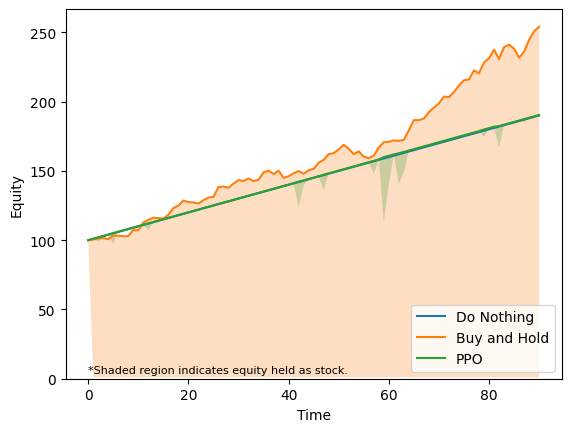

In [171]:
from PIL import ImageColor

for strategy_name, strategy_results in result_dfs.items():
    equity_plot = plt.plot(timeline, strategy_results["equity"], label=strategy_name)
    col = np.concatenate([np.array(ImageColor.getcolor(equity_plot[0].get_color(), "RGB")), [256]]) / 256
    plt.stackplot(timeline,
                  np.array(strategy_results["cash"], dtype=float),
                  np.array(strategy_results["equity"]-strategy_results["cash"], dtype=float),
                  colors=[(0,0,0,0), col * np.array([1,1,1,0.25])])
plt.text(0,4, "*Shaded region indicates equity held as stock.", fontsize=8)
plt.legend(loc="lower right")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.show()

In [172]:
total_investment = result_dfs["Do Nothing"]["equity"].iloc[-1]
for strategy_name, strategy_results in result_dfs.items():
    strategy_final_results = strategy_results.iloc[-1]
    print(f"{strategy_name}:")
    print("Final equity as percent of investment: %.3f%%" % (strategy_final_results["equity"] / total_investment * 100))
    effann = (strategy_final_results["equity"]/total_investment) ** (1/(episode_length/252)) * 100 -100
    print("Equivalent annual growth rate: %s%.3f%%" % ("+" if effann >= 0 else "", effann))
    print()

Do Nothing:
Final equity as percent of investment: 100.000%
Equivalent annual growth rate: +0.000%

Buy and Hold:
Final equity as percent of investment: 133.734%
Equivalent annual growth rate: +125.672%

PPO:
Final equity as percent of investment: 100.213%
Equivalent annual growth rate: +0.597%

